# [DRAFT] Computing_WO_from_S2_ARD <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environments
* <b>Products Used:</b> [Sentinel 2A ARD](https://explorer.sandbox.dea.ga.gov.au/products/ga_s2am_ard_3) and [Sentinel 2B ARD](https://explorer.sandbox.dea.ga.gov.au/products/ga_s2bm_ard_3)
* <b>Context of WOfS:</b> [DEA Water Observations](DEA_Water_Observations.ipynb)

## Background
This notebook demonstrates how WO can be applied to Sentinel 2 (S2) ARD imagery. 
In this example, the `WO codebase` from [DEA Water Observations](DEA_Water_Observations.ipynb) has been used with some slight changes to input bands. 
This can be done by downloading the .zip of [wofs](https://github.com/GeoscienceAustralia/wofs/tree/master). 

If you are using the DEA Sandbox, upload it to the file browser in a safe spot, then unzip it.
1. Update the spectral bands in wofs > wofls.py > spectral_bands().
2. At line 93, add `"nbart_coastal_aerosol"`.
3. Update `"nbart_nir"` to `"nbart_nir_1"` and add another line for `"nbart_nir_2"` underneath.
4. Update `"nbart_swir_1"` to `"nbart_swir_2"` and `"nbart_swir_2"` to `"nbart_swir_3"`

WO was designed for Landsat imagery, hence there are some artefacts in the S2 outputs and adjustments will need to be made to improve data quality. 
This was explored by testing different Fmask parameters, and [Combining New Fmask with S2 ARD and Applying WO](Incorporatig_Fmask_ARD.ipynb).

## Description
The Water Observations product processes data on a granular scale, but sometimes it is more efficient to only generate outputs for what is needed.
To compute WO from S2 ARD at a specific area of interest, we can either set a bounding box by providing x and y coordinates for each edge, or incorporating a vector file as a `GeoDataFrame`. 
These boundaries act as borders to limit where to process data. A vector file can contain multiple polygons and allow you to choose which polygon to process and view.

Further anlaysis can then be conducted on each resulting `xarray.Dataset`. Further anlaysis can then be conducted on each resulting `xarray.Dataset`.

Bounding Box Option
1. First we set the x and y coordinates of the bounding box, and choose a start and end date
2. Extract satellite data from DEA that fit the requirements of step 1.
3. Apply woffles_ard() to classify the image
4. Plot the classified output for the polygon extent. 

Vector option
1. First we open the vector file as a `geopandas.GeoDataFrame`
2. Iterate through each polygon in the `GeoDataFrame`, and extract satellite data from DEA
3. Apply woffles_ard() to classify the image
4. Plot the classified output for the polygon extent. 

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube.utils` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand.

In [1]:
%matplotlib inline

import datacube
import rasterio.crs
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
from datetime import datetime, timedelta
from datacube.utils.geometry import Geometry, CRS

sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices #don't think this was used
from dea_tools.plotting import rgb, plot_wo
from dea_tools.temporal import time_buffer # optional if the date for testing is already known
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster

# local copy of WOfs - input bands have been adjusted according to README.rst
# update the filepath as needed
sys.path.insert(1, "../S2_WO_Quality_Testing/wofls/wofs-1.6.5/")
from wofs.wofls import woffles_ard

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Australia data. 
Using Dask can help when working with large analyses (either in space or time) as it breaks data into manageable chunks that can be easily stored in memory.

In [2]:
dc = datacube.Datacube(app='Cloud_Masking_polygons')
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38397,Workers: 1
Dashboard: /user/yukie.nip@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:33103,Total threads: 2
Dashboard: /user/yukie.nip@ga.gov.au/proxy/34425/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:46359,


## Analysis parameters
Parameters associated with physical satellite properties will not need changing throughout this notebook, hence they are fixed. 
Parameters we would like to test and swap out, such as algorithm parameters, are considered dynamic. 
Keeping these parameters in separate cells makes it easier to update the notebook.

### Fixed Parameters 
* `products` : A list of product names to load from the datacube e.g. `["ga_s2am_ard_3", "ga_s2bm_ard_3"]`
* `measurements` : A list of band names to load from the satellite product e.g. `["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Sentinel 2, this is `(-10, 10)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection. If using vector file inputs, we will adopt the CRS of those files.
* `align` : How to align the x, y coordinates respect to each pixel. Sentinel 2 Collection 3 should be centre aligned `align = (5, 5)` if data is loaded in its native UTM zone projection, e.g. `'EPSG:32756'`
* `maturity`: Maturity of a dataset is dictated by the quality of the ancillary information used to generate the product. The maturity levels are Near Real Time (NRT), Interim, and Final. The final ARD should be of highest quality.

In [3]:
# Fixed parameters
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
# Select the bands of interest. The red-edge is not needed for WO
measurements = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]
resolution = (-10, 10)
output_crs = "EPSG:3577"
align = (5, 5) 
maturity = "final" 

### Dynamic Parameters
* `bounding box`: This is two sets of x and y coordinates to establish the processing extent.
* `time`: The start and end date. 
Imagery found with dates that match this period will be loaded.
* `time_of_interest` : Enter a time, in units YYYY-MM-DD, around which to load satellite data e.g. `'2019-01-01'`
* `time_buff` : A buffer of a given duration (e.g. days) around the time_of_interest parameter, e.g. `'30 days'`. 
For testing, we already know where and when to look, so the buffer can be reduced to 1 day to speed up processing time.
* `vector_file` : A path to a vector file (ESRI Shapefile or GeoJSON). 
Vector files are used to group polygons by days for easier loading.
* `attribute_col` : A column in the vector file used to label the output `xarray` datasets containing satellite images. 
Each row of this column should have a unique identifier

## Sample Inputs
This notebook demonstrates how the WO classifier can be applied to a S2 area of interest. 
The test site is defined by x y coordinates.
Later in this notebook, we define a test site with a geojson.

## Area of Interest
The area of interest can be marked with a bounding box defined by coordinates. 
This information can be stored in a query to make loading ARD easier.

In [4]:
# Bounding box: set x and y coordinates
query = {"x": (118.73674366260991, 119.48038728576063),
         "y": (-27.759292555788853, -28.252057113033352),
         "time": ("2023-04-02", "2023-04-04"),
         'dask_chunks':{}}

## Loading Satellite Data
Here, we load the satellite data that satisfies the requirements of the query we just made, along with the fixed parameters we defined earlier.

In [5]:
# Load ARD
ds = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
            dataset_maturity="final",
            measurements=measurements,
            resolution=resolution,
            output_crs=output_crs,
            align=align,
            group_by='solar_day',
            **query)
# WO expects the fmask layer to be named 'fmask', so we need to rename it.
ds['fmask'] = ds['oa_fmask']

### Check Data
We can now use the `dea_plotting.rgb` function to plot our loaded data as a three-band RGB plot. The output is very cloudy!

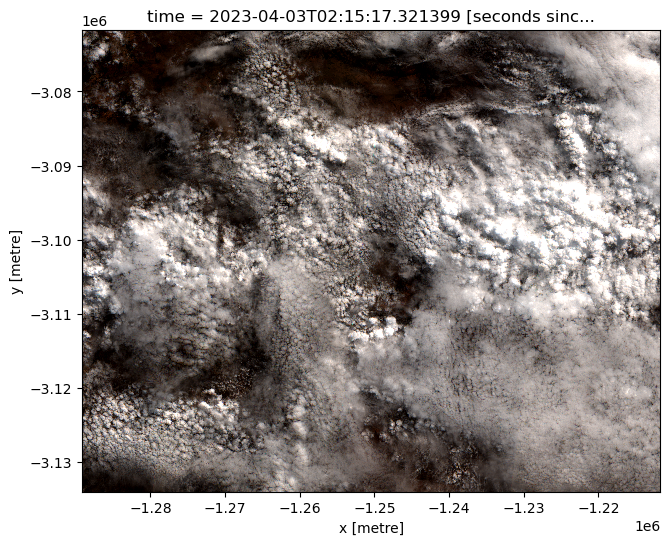

In [6]:
# Check data present
rgb(ds)

## Compute Water Observations
Now you have all the data needed to compute a Water Observations Feature Layer.

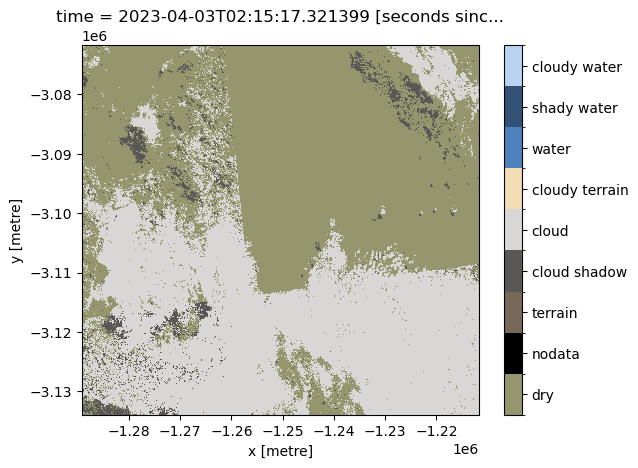

In [7]:
# Apply woffles_ard
wofl = woffles_ard(ds.isel(time=0), dsm=None)
plot_wo(wofl)

## Defining an Area of Interest with a Vector File
Many users need to run analyses on their own areas of interest. 
A common use case involves running the same analysis across multiple polygons in a vector file (e.g. ESRI Shapefile or GeoJSON). 
If we have a vector file containing multiple polygons, we can use the python package [geopandas](https://geopandas.org/) to open it as a `GeoDataFrame`. 
We can then iterate through each geometry and extract satellite data corresponding with the extent of each geometry. 
Further anlaysis can then be conducted on each resulting `xarray.Dataset`.
The sample inputs `Sample_Sites/Aus_Sample_Granules.geojson` is a set of 27 granules randomly spaced across Australia. 
A smaller area `Sample_Sites/Sample_Site.geojson` can be used as a faster alternative. 
This area has been selected to provide an example of an S2 WO artefact, where an error in one granule has revealed the granule boundary. 

In [ ]:
# Path to vector file
vector_file = '../S2_WO_Quality_Testing/Sample_Sites/Sample_Site.geojson'
# Attribute used to identify and refer to different polygons. Important if file has multiple polygons.
attribute_col = 'ID'

# Dynamic Parameters - if the date of image capture is known, then a smaller time buffer can be used.
time_of_interest = '2023-04-03'
# Time buffer helps find data on adjacent dates if no data is available for the time of interest.
time_buff = '1 days'

# Check structure of file
# Use this to understand what you're iterating through
gdf = gpd.read_file(vector_file)
# Note what values are used as ID for the polygons. This will be used later when choosing which polygon to perform an analysis on.
gdf.head()

### Defining a Datacube Query Object for Vector file
We then create a dictionary that will contain the parameters that will be used to load data from the DEA data cube.
This function extracts the location information from the geojson and includes the time of interest in the query. Defining a function lets you use it as many times as you'd like afterwards.
> **Note:** We do not include the usual `x` and `y` spatial query parameters here, as these will be taken directly from each of our vector polygon objects.

In [ ]:
# Query object for vector file
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf):
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Find datasets that match the date and polygon provided.
    dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577" if no data is found to prevent an error    
    native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    #creating query object
    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             #'group_by': 'solar_day',
             'dask_chunks':{}
             }

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})                                            
                                              
    return query     

We can then plot the `geopandas.GeoDataFrame` on an interactive map to make sure it covers the area of interest we are concerned with.

In [ ]:
# Use second column as our guide
# This is the information that will show up when we hover the mouse over a polygon
gdf.explore(column=[2])

## Loading Satellite Data
Here we will iterate through each row of the `geopandas.GeoDataFrame` and load satellite data.
The results will be appended to a dictionary object which we can later index to analyse each dataset.


In [ ]:
# Dictionary to save results 
results = {}

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    
    print(f'Feature: {index + 1}/{len(gdf)}')

    query = loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf)
    # Load Sentinel 2
    ds = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
            dataset_maturity="final",
            measurements=measurements,
            resolution=resolution,
            output_crs=output_crs,
            align=align,
            group_by='solar_day',
            **query)
    # WO expects the fmask layer to be named 'fmask', so we need to rename it. 
    # This line copies the values of the 'oa_fmask' attribute to a new attribute 'fmask'. 
    ds['fmask'] = ds['oa_fmask']

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[attribute_col]): ds})


## Inspect Results
Our `results` dictionary will contain `xarray` objects labelled by the unique `attribute column` values we specified in the `Analysis parameters` section:

In [ ]:
results

In [ ]:
# View dataset for a slice of time.
ds.isel(time=0)

### Plot an RGB image
Set the ID number of the polygon of interest as the key. 
Granules have ID structures like 50HMH. 
The small sample polygon has ID = 3

We can now use the `dea_plotting.rgb` function to plot our loaded data as a three-band RGB plot. The output is very cloudy!

In [ ]:
key = '3'
rgb(results[key], col='time', size=4)

## Compute Water Observations
Now you have all the data needed to compute a Water Observations Feature Layer.

In [ ]:
wofl = woffles_ard(ds.isel(time=0), dsm=None)

# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf.iloc[[index]], wofl)

# Mask dataset to set pixels outside the polygon to `NaN`
wofl = wofl.where(mask)

# Append results to a dictionary using the attribute
# column as a key
results.update({str(row[attribute_col]): wofl})

# Plot output
plot_wo(wofl, figsize=(10,4))


## Further Improvements
As you can see, there is a large error in the WO output when we look at `Sample_Site.geojson`. 
This is because Fmask and WO were originally designed for Landsat, which has thermal bands that are good at separating clouds from other surfaces. 
Sentinel 2 doesn't have these bands, so we need to consider alternative solutions.

We have created some Fmask tiles from different input parameters to see if we can improve the data quality. 
These tiles can be merged with S2 ARD bands and sent through WO for evaluation in [Combining New Fmask with S2 ARD and Applying WO](Incorporatig_Fmask_ARD.ipynb).


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)